## 1. Set up environment, load data

In [1]:
# install.packages("compositions")
# install.packages("ggdist")
library(phyloseq, verbose=F)
library(ggplot2, verbose=F)
library(compositions, verbose=F)
library(reshape2, verbose=F)
library(tidyr, verbose=F)
library(dplyr, verbose=F)
library(ggdist, verbose=F)
library(ggpubr, verbose=F)
# load in master phyloseq R data object
load("../02-diversity/master_phyloseq.RData")
# set up directory to save figures
system("mkdir img")
# check phyloseq object
ps.dat
# pull metadata table
map <- sample_data(ps.dat)

Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following objects are masked from ‘package:stats’:

    anova, cor, cov, dist, var


The following object is masked from ‘package:graphics’:

    segments


The following objects are masked from ‘package:base’:

    %*%, norm, scale, scale.default



Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14111 taxa and 1960 samples ]
sample_data() Sample Data:       [ 1960 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 14111 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 14111 tips and 14109 internal nodes ]

## 2. Filter data to include only those teeth with multiple sampling across visits

In [2]:
map$studyID_FDI <- paste(map$study_id, ".", map$FDI_code, sep="")

Only looking at visit one to three here

In [3]:
map.v1v3 <- map[map$visit_num == 1 | map$visit_num == 3,]
# count the number of times that a study ID + FDI code appears in the data
counts <- data.frame(table(map.v1v3$studyID_FDI))
# pull records that occur more than one time
map.v1v3 <- map.v1v3[map.v1v3$studyID_FDI %in% counts$Var1[counts$Freq > 1],]
# reorder
map.v1v3 <- map.v1v3[order(map.v1v3$studyID_FDI),]
# number of samples
dim(map.v1v3)
# make sure you aren't left with singletons, this command should come back as all TRUE
# data.frame(table(map.v1v3$studyID_FDI))$Freq == 2

# get average number of days between visits
# first melt visit date column into a data frame of two columns
dates <- as.data.frame(matrix(map.v1v3$visit_date, ncol=2, byrow=TRUE))
# average difference between date of visit one and visit two
mean(as.Date(as.character(dates$V2), format="%m/%d/%Y")-as.Date(as.character(dates$V1), format="%m/%d/%Y"))

[1] 408  27

Time difference of 400.701 days

## 3. Volatility analyses

Because we have the full range of analyses in the other notebook (volatility.ipynb), only focus on the figures and analyses we want to add in the paper here

### 3.1 All teeth over visit one and three

In [4]:
counts <- otu_table(ps.dat)[row.names(map.v1v3),]
dim(counts)
# remove asvs with zero count after filtering
counts <- counts[,colSums(counts) > 0]
dim(counts)

# make sure data is all numeric
counts <- apply(counts,c(1,2),function(x) as.numeric(as.character(x)))
# perform clr transformation to the data
counts.clr <- clr(counts)
# distance
counts.dist <- dist(counts.clr, method="euclidean")
# pca
counts.pca <- prcomp(counts.dist)
# extract the amount of variance for first four components
pc1 <- round(counts.pca$sdev[1]^2/sum(counts.pca$sdev^2),4) * 100
pc2 <- round(counts.pca$sdev[2]^2/sum(counts.pca$sdev^2),4) * 100
pc3 <- round(counts.pca$sdev[3]^2/sum(counts.pca$sdev^2),4) * 100
pc4 <- round(counts.pca$sdev[4]^2/sum(counts.pca$sdev^2),4) * 100

# extract scores for each sample for first four components
pca <- data.frame(PC1 = counts.pca$x[,1],
                  PC2 = counts.pca$x[,2],
                  PC3 = counts.pca$x[,3],
                  PC4 = counts.pca$x[,4])
# add metadata to the pca scores
pca$studyID_FDI <- map.v1v3$studyID_FDI # individual tooth identifier
pca$hiv_status <- map.v1v3$hiv_status # cohort to split frames
pca$hiv_status <- factor(pca$hiv_status, levels=c("HI", "HEU", "HUU"))
pca$tooth_health <- map.v1v3$tooth_health # treatment
pca$visit_num <- map.v1v3$visit_num # time point data

[1]   408 14111

[1]   408 10945

In [5]:
# compute volatility -- euclidean distance over CLR transformed count data (aitchison distance between pairs)
# first need to melt our distance matrix to get pairs of samples and their distance
counts.melt <- melt(as.matrix(counts.dist))
# modify sample names in columns
counts.melt$Var1 <- gsub("V.*PQ", ".", counts.melt$Var1)
counts.melt$Var2 <- gsub("V.*PQ", ".", counts.melt$Var2)
# clean up data
counts.melt <- counts.melt[counts.melt$value != 0, ]
counts.melt$match <- ifelse(counts.melt$Var1 == counts.melt$Var2, "TRUE", "FALSE")
# get only those that are duplicated samples, clean up again
matches <- counts.melt[counts.melt$match == "TRUE",]
matches <- as.data.frame(matches[,-2])
matches <- matches[!duplicated(matches),]

# get temporary metadata file to merge in with your distance metrics
temp <- as.data.frame(cbind(map.v1v3$studyID_FDI, map.v1v3$hiv_status))
temp <- temp[!duplicated(temp),]
# final dataframe
dist_diff <- merge(x=matches, y=temp, by.x="Var1", by.y="V1")

# some summary statistics on these distances
group_by(dist_diff, V2) %>%
  summarise(
    count = n(),
    median = median(value, na.rm = TRUE),
    SD = sd(value, na.rm = TRUE)
)

V2,count,median,SD
<chr>,<int>,<dbl>,<dbl>
HEU,59,21.98312,3.097594
HI,74,22.26461,4.259307
HUU,63,23.50762,4.919513


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.”
Warning message:
“Use of `avg_values$avg_value` is discouraged.
ℹ Use `avg_value` instead.”
Warning message:
“Use of `avg_values$avg_value` is discouraged.
ℹ Use `avg_value` instead.”


png 
  2

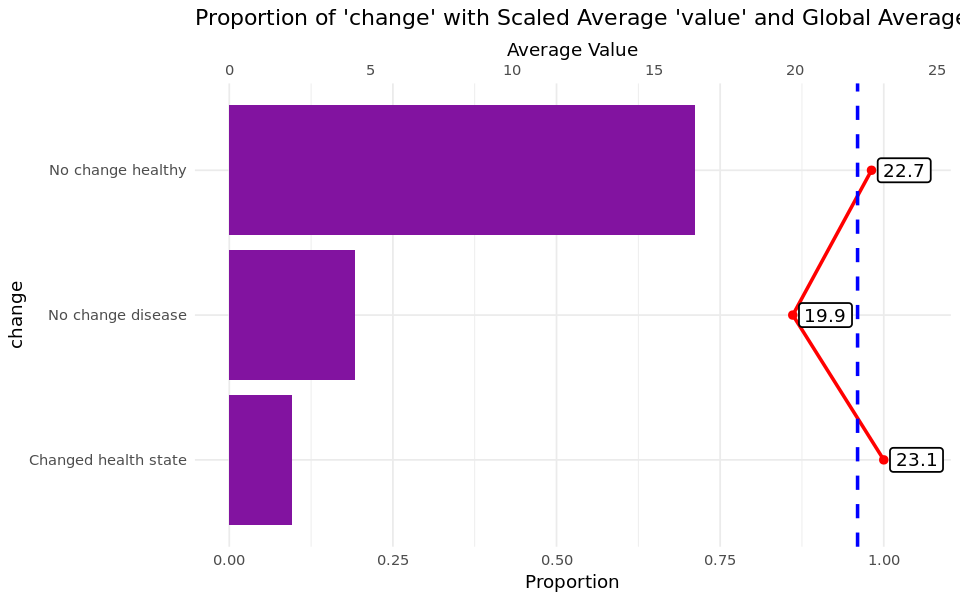

In [6]:
## UPDATE: Want to get a figure that illustrates the degree of change and frequency of specific types of change for each group
temp <- as_tibble(map.v1v3[map.v1v3$hiv_status == "HI",])
temp <- temp %>%
    select(studyID_FDI, visit_num, tooth_health) %>%
    pivot_wider(names_from=visit_num, values_from=tooth_health) 
colnames(temp) <- c("studyID_FDI", "visit1", "visit3")
temp$change <- paste(temp$visit1, "to", temp$visit3, sep="_")
temp <- na.omit(temp)
temp <- temp %>% filter_all(all_vars(. !="NULL"))

# merge with change info
changelist <- merge(x=dist_diff, y=temp, by.x="Var1", by.y="studyID_FDI")
# as.factor(changelist$change)
##### for figure clarity, collapse all change variables 
changelist <- changelist %>%
                mutate(change = recode(change,
                       'D_to_D' = 'No change disease',
                       'D_to_H' = 'Changed health state',
                       'E_to_D' = 'Changed health state',
                       'E_to_E' = 'No change disease',
                       'E_to_H' = 'Changed health state',
                       'H_to_D' = 'Changed health state',
                       'H_to_E' = 'Changed health state',
                       'H_to_H' = 'No change healthy'))

# head(changelist)
changelist$change <- factor(changelist$change, levels=c("Changed health state", "No change disease", "No change healthy"))

# Load necessary libraries
library(ggplot2)
library(dplyr)

df <- changelist

# Calculate the average 'value' for each 'change' group
avg_values <- df %>%
  group_by(change) %>%
  summarise(avg_value = mean(value))

# Calculate global average value
global_avg_value <- mean(df$value)

# Calculate total counts for proportions
total_count <- nrow(df)

# spread out so we can see x axis more  
options(repr.plot.width = 8, repr.plot.height =5)

# Plot the proportion bar chart and overlay the line for average values, then flip coordinates
p <- ggplot(df, aes(x = change)) +
  # Bar chart for proportion of 'change'
  geom_bar(aes(y = ..count.. / total_count), stat = "count", fill = "#8213A0") +
  
# "HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA"

  # Line graph for scaled average 'value'
  geom_line(data = avg_values, aes(x = change, y = avg_value / max(avg_value), group = 1), 
            color = "red", linewidth = 1) +
  geom_point(data = avg_values, aes(x = change, y = avg_value / max(avg_value)), 
             color = "red", size = 2) +
    # Add line for global average
  geom_hline(yintercept = global_avg_value / max(avg_values$avg_value), 
             linetype = "dashed", color = "blue", size = 1) +

  # Add labels with boxes to average points, offset so they don't cover the points
  geom_label(data = avg_values, 
             aes(x = change, 
                 y = avg_value / max(avg_values$avg_value), 
                 label = round(avg_value, 1)),  # Round to 1 decimal place
             nudge_y = 0.05,  # Offset vertically
             label.size = 0.5,  # Thickness of the box
             fill = "white",  # Background color of the box
             color = "black") +  # Color of the text
             

  
  # Labels and title
  labs(y = "Proportion / Scaled Average Value", 
       title = "Proportion of 'change' with Scaled Average 'value' and Global Average") +
  
  # Set limits for the primary y-axis (proportions)
  ylim(0, 1) +  # Adjust this if necessary
  
  # Secondary y-axis for the line plot (showing the original scale of avg_value)
  scale_y_continuous(
    sec.axis = sec_axis(~ . * max(avg_values$avg_value), name = "Average Value"),
    name = "Proportion"
  ) +
  
  # Flip the coordinates to make horizontal bars
  coord_flip() +
  
  theme_minimal()

p

pdf("newvol_plot.HI.pdf")
p
dev.off()

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Use of `avg_values$avg_value` is discouraged.
ℹ Use `avg_value` instead.”
Warning message:
“Use of `avg_values$avg_value` is discouraged.
ℹ Use `avg_value` instead.”


png 
  2

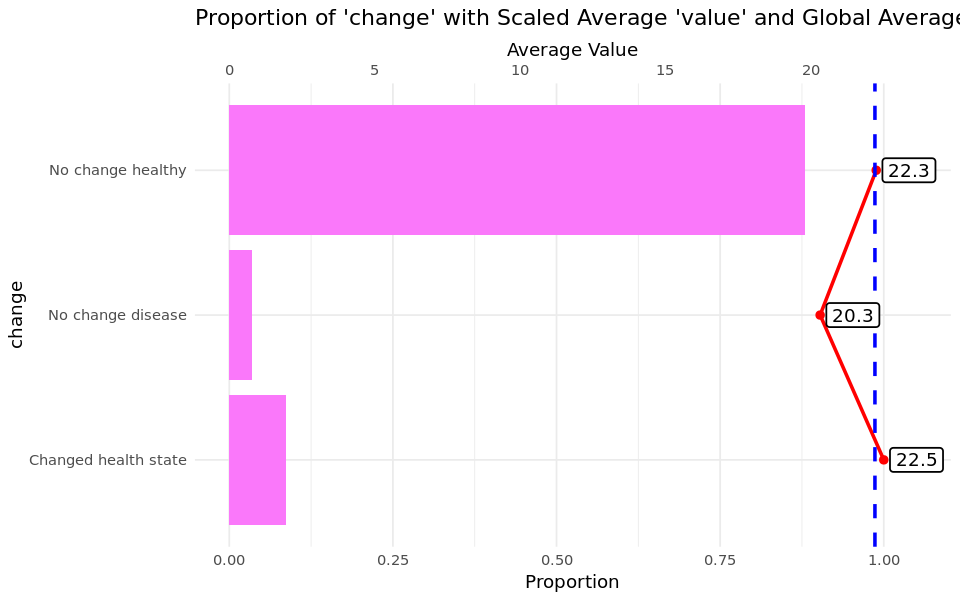

In [7]:
temp <- as_tibble(map.v1v3[map.v1v3$hiv_status == "HEU",])
temp <- temp %>%
    select(studyID_FDI, visit_num, tooth_health) %>%
    pivot_wider(names_from=visit_num, values_from=tooth_health) 
colnames(temp) <- c("studyID_FDI", "visit1", "visit3")
temp$change <- paste(temp$visit1, "to", temp$visit3, sep="_")
temp <- na.omit(temp)
temp <- temp %>% filter_all(all_vars(. !="NULL"))

# merge with change info
changelist <- merge(x=dist_diff, y=temp, by.x="Var1", by.y="studyID_FDI")
# as.factor(changelist$change)
##### for figure clarity, collapse all change variables 
changelist <- changelist %>%
                mutate(change = recode(change,
                       'D_to_D' = 'No change disease',
                       'D_to_H' = 'Changed health state',
                       'E_to_D' = 'Changed health state',
                       'E_to_E' = 'No change disease',
                       'E_to_H' = 'Changed health state',
                       'H_to_D' = 'Changed health state',
                       'H_to_E' = 'Changed health state',
                       'H_to_H' = 'No change healthy'))

# head(changelist)
changelist$change <- factor(changelist$change, levels=c("Changed health state", "No change disease", "No change healthy"))

# Load necessary libraries
library(ggplot2)
library(dplyr)

df <- changelist

# Calculate the average 'value' for each 'change' group
avg_values <- df %>%
  group_by(change) %>%
  summarise(avg_value = mean(value))

# Calculate global average value
global_avg_value <- mean(df$value)

# Calculate total counts for proportions
total_count <- nrow(df)

# spread out so we can see x axis more  
options(repr.plot.width = 8, repr.plot.height =5)

# Plot the proportion bar chart and overlay the line for average values, then flip coordinates
p <- ggplot(df, aes(x = change)) +
  # Bar chart for proportion of 'change'
  geom_bar(aes(y = ..count.. / total_count), stat = "count", fill = "#FA78FA") +
  
# "HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA"


  # Line graph for scaled average 'value'
  geom_line(data = avg_values, aes(x = change, y = avg_value / max(avg_value), group = 1), 
            color = "red", linewidth = 1) +
  geom_point(data = avg_values, aes(x = change, y = avg_value / max(avg_value)), 
             color = "red", size = 2) +
    # Add line for global average
  geom_hline(yintercept = global_avg_value / max(avg_values$avg_value), 
             linetype = "dashed", color = "blue", size = 1) +

  # Add labels with boxes to average points, offset so they don't cover the points
  geom_label(data = avg_values, 
             aes(x = change, 
                 y = avg_value / max(avg_values$avg_value), 
                 label = round(avg_value, 1)),  # Round to 1 decimal place
             nudge_y = 0.05,  # Offset vertically
             label.size = 0.5,  # Thickness of the box
             fill = "white",  # Background color of the box
             color = "black") +  # Color of the text
             

  
  # Labels and title
  labs(y = "Proportion / Scaled Average Value", 
       title = "Proportion of 'change' with Scaled Average 'value' and Global Average") +
  
  # Set limits for the primary y-axis (proportions)
  ylim(0, 1) +  # Adjust this if necessary
  
  # Secondary y-axis for the line plot (showing the original scale of avg_value)
  scale_y_continuous(
    sec.axis = sec_axis(~ . * max(avg_values$avg_value), name = "Average Value"),
    name = "Proportion"
  ) +
  
  # Flip the coordinates to make horizontal bars
  coord_flip() +
  
  theme_minimal()

p

pdf("newvol_plot.HEU.pdf")
p
dev.off()

Warning message:
“Values from `tooth_health` are not uniquely identified; output will contain
list-cols.
• Use `values_fn = list` to suppress this warning.
• Use `values_fn = {summary_fun}` to summarise duplicates.
• Use the following dplyr code to identify duplicates.
  {data} |>
  dplyr::summarise(n = dplyr::n(), .by = c(studyID_FDI, visit_num)) |>
  dplyr::filter(n > 1L)”
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Use of `avg_values$avg_value` is discouraged.
ℹ Use `avg_value` instead.”
Warning message:
“Use of `avg_values$avg_value` is discouraged.
ℹ Use `avg_value` instead.”


png 
  2

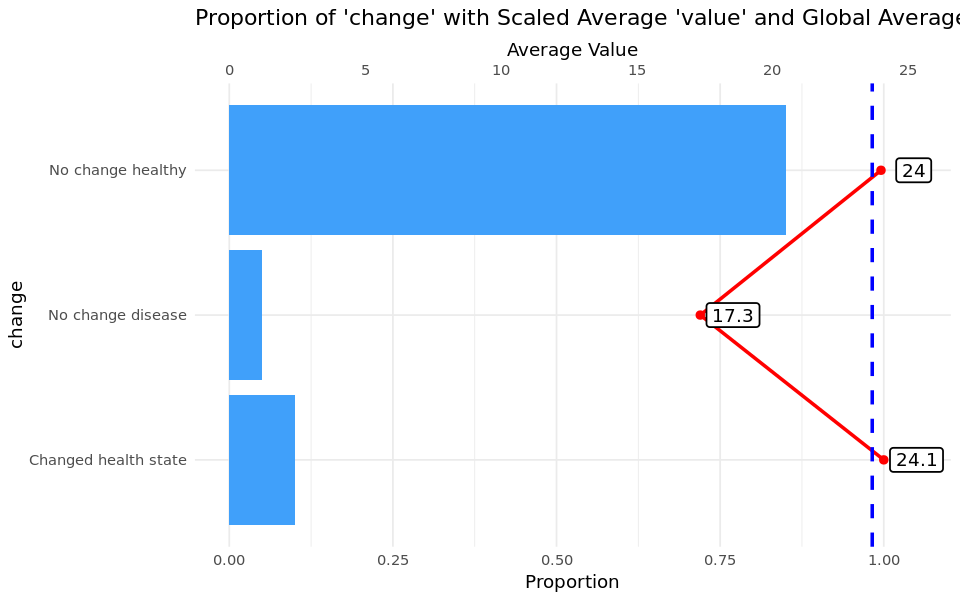

In [8]:
temp <- as_tibble(map.v1v3[map.v1v3$hiv_status == "HUU",])
temp <- temp %>%
    select(studyID_FDI, visit_num, tooth_health) %>%
    pivot_wider(names_from=visit_num, values_from=tooth_health) 
colnames(temp) <- c("studyID_FDI", "visit1", "visit3")
temp$change <- paste(temp$visit1, "to", temp$visit3, sep="_")
temp <- na.omit(temp)
temp <- temp %>% filter_all(all_vars(. !="NULL"))

# merge with change info
changelist <- merge(x=dist_diff, y=temp, by.x="Var1", by.y="studyID_FDI")
# as.factor(changelist$change)
##### for figure clarity, collapse all change variables 
changelist <- changelist %>%
                mutate(change = recode(change,
                       'D_to_D' = 'No change disease',
                       'D_to_H' = 'Changed health state',
                       'E_to_D' = 'Changed health state',
                       'E_to_E' = 'No change disease',
                       'E_to_H' = 'Changed health state',
                       'H_to_D' = 'Changed health state',
                       'H_to_E' = 'Changed health state',
                       'H_to_H' = 'No change healthy'))

# head(changelist)
changelist$change <- factor(changelist$change, levels=c("Changed health state", "No change disease", "No change healthy"))

# Load necessary libraries
library(ggplot2)
library(dplyr)

df <- changelist

# Calculate the average 'value' for each 'change' group
avg_values <- df %>%
  group_by(change) %>%
  summarise(avg_value = mean(value))

# Calculate global average value
global_avg_value <- mean(df$value)

# Calculate total counts for proportions
total_count <- nrow(df)

# spread out so we can see x axis more  
options(repr.plot.width = 8, repr.plot.height =5)

# Plot the proportion bar chart and overlay the line for average values, then flip coordinates
p <- ggplot(df, aes(x = change)) +
  # Bar chart for proportion of 'change'
  geom_bar(aes(y = ..count.. / total_count), stat = "count", fill = "#40A0FA") +
  
# "HI"="#8213A0", "HEU"="#FA78FA", "HUU"="#40A0FA"


  # Line graph for scaled average 'value'
  geom_line(data = avg_values, aes(x = change, y = avg_value / max(avg_value), group = 1), 
            color = "red", linewidth = 1) +
  geom_point(data = avg_values, aes(x = change, y = avg_value / max(avg_value)), 
             color = "red", size = 2) +
    # Add line for global average
  geom_hline(yintercept = global_avg_value / max(avg_values$avg_value), 
             linetype = "dashed", color = "blue", size = 1) +

  # Add labels with boxes to average points, offset so they don't cover the points
  geom_label(data = avg_values, 
             aes(x = change, 
                 y = avg_value / max(avg_values$avg_value), 
                 label = round(avg_value, 1)),  # Round to 1 decimal place
             nudge_y = 0.05,  # Offset vertically
             label.size = 0.5,  # Thickness of the box
             fill = "white",  # Background color of the box
             color = "black") +  # Color of the text
             

  
  # Labels and title
  labs(y = "Proportion / Scaled Average Value", 
       title = "Proportion of 'change' with Scaled Average 'value' and Global Average") +
  
  # Set limits for the primary y-axis (proportions)
  ylim(0, 1) +  # Adjust this if necessary
  
  # Secondary y-axis for the line plot (showing the original scale of avg_value)
  scale_y_continuous(
    sec.axis = sec_axis(~ . * max(avg_values$avg_value), name = "Average Value"),
    name = "Proportion"
  ) +
  
  # Flip the coordinates to make horizontal bars
  coord_flip() +
  
  theme_minimal()

p
pdf("newvol_plot.HUU.pdf")
p
dev.off()